In [1]:
import pandas as pd
import time
import datetime
!pip install praw
import praw
import praw.exceptions
import numpy as np
from scipy.sparse import csr_matrix
import nltk
import matplotlib.pyplot as plt
import datetime
from datetime import date
import time
import pickle
import scipy
import scipy.sparse as sps
!pip install louvain
import louvain
import igraph as ig

<ipython-input-1-48d300182c17>:18: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [2]:
# create reddit instance
reddit = praw.Reddit(
    client_id='ahFrijCpODYG3b426gka8w',
    client_secret='FsRm_xJ3u9C_dtj3fqur3K-rGNMwtQ',
    user_agent='getting_data',
    check_for_async=False)

In [3]:

keyword = ["Feminism"]

# Search for subreddits related to the keyword
subreddits = reddit.subreddits.search(keyword, limit=100)
DF = pd.DataFrame(vars(subreddit) for subreddit in subreddits)
DF = DF[['display_name','subscribers']].sort_values(by='subscribers',ascending = False)

# show result
DF.dropna(inplace=True)
display(DF)
subreddits_name_list = list(DF['display_name'])

,display_name,subscribers
72,AskReddit,47059918.0
46,memes,32359401.0
11,TwoXChromosomes,13664277.0
42,unpopularopinion,4293126.0
59,changemyview,3644107.0
...,...,...
87,FeminismMiddleGround,41.0
14,Gynocentrism_feminism,36.0
89,FeminismInAction,31.0
93,LazyFeminismJokes,23.0


In [4]:
# Define a function to read posts from a specified subreddit.
def read_reddit(subreddit_name, total_posts_to_retrieve,
                time_filter, sort_mode, keywords, batch_size = 250):

    subreddit = reddit.subreddit(subreddit_name)
    all_posts = []
    retrieved_posts = 0
    current_batch = 0
    after_param = ''

    # Loop to read reddit posts in batches until the desired number of posts is retrieved.
    while retrieved_posts < total_posts_to_retrieve:
        remaining_posts = total_posts_to_retrieve - retrieved_posts
        posts_to_retrieve = min(remaining_posts, batch_size)
        collected_posts = list(subreddit.search(keywords,
                                                limit=posts_to_retrieve,
                                                time_filter=time_filter,
                                                sort=sort_mode,
                                                params={'after': after_param}))
        if not collected_posts: break
        all_posts.extend(collected_posts)
        retrieved_posts += len(collected_posts)
        current_batch += 1
        after_param = 't3_' + all_posts[-1].id

    df = pd.DataFrame(vars(post) for post in all_posts) # turn into dataframe
    print('a total of ' + str(len(df)) + ' posts have been collected out of '
                        + str(total_posts_to_retrieve))
    return df

In [5]:
# Set search criteria for the Reddit API
total_posts_to_retrieve = 1000
time_filter = 'year' # "all", "day", "hour", "month", "week", or "year"
sort_mode = 'top' # "relevance", "hot", "top", "new", or "comments"
keywords = 'feminism'

dfs = []
# Iterate over each subreddit in the list
for subreddit_name in subreddits_name_list :
    print(subreddit_name)
    df = read_reddit(subreddit_name, total_posts_to_retrieve, time_filter,
                 sort_mode, keywords, batch_size=100)
    dfs.append(df)


# Merge all the collected dataframes into a single dataframe
final_df = pd.concat(dfs, ignore_index=True)

# Select specific columns of interest from the merged dataframe
final_df = final_df[['id','created','subreddit','title','selftext','author',
         'author_fullname','upvote_ratio','ups','num_comments']]

# Convert timestamp to a readable date format
final_df["created"] = [datetime.date.fromtimestamp(i) for i in final_df["created"]]

# Save the final dataframe to a CSV file
final_df.to_csv('/content/drive/MyDrive/Network_science/feminism_reddit.csv', index=True)

# Display the final dataframe
display(final_df)

AskReddit
a total of 10 posts have been collected out of 1000
memes
a total of 3 posts have been collected out of 1000
TwoXChromosomes
a total of 171 posts have been collected out of 1000
unpopularopinion
a total of 2 posts have been collected out of 1000
changemyview
a total of 26 posts have been collected out of 1000
teenagers
a total of 75 posts have been collected out of 1000
Conservative
a total of 8 posts have been collected out of 1000
SubredditDrama
a total of 0 posts have been collected out of 1000
justneckbeardthings
a total of 36 posts have been collected out of 1000
TrollXChromosomes
a total of 17 posts have been collected out of 1000
NotHowGirlsWork
a total of 147 posts have been collected out of 1000
socialism
a total of 28 posts have been collected out of 1000
MensRights
a total of 224 posts have been collected out of 1000
IncelTears
a total of 81 posts have been collected out of 1000
TopMindsOfReddit
a total of 20 posts have been collected out of 1000
JordanPeterson
a t

,id,created,subreddit,title,selftext,author,author_fullname,upvote_ratio,ups,num_comments
0,14wo2z8,2023-07-11,AskReddit,What's the diference betwew toxic masculinity ...,,Poch1212,t2_134q8a5s,0.75,2,20
1,14vb4ek,2023-07-09,AskReddit,What are the best books on the subject of Femi...,,Adventurous-Ebb6556,t2_8g1mpjgi,1.00,2,7
2,1525llh,2023-07-17,AskReddit,Who defines what Masculinity and Feminity is?,,CptJackParo,t2_djcaeajk,0.75,2,9
3,157g9ox,2023-07-23,AskReddit,do you consider yourself a feminist and what d...,,traanniecum,t2_f4lajpcul,0.76,2,4
4,1cokdwc,2024-05-10,AskReddit,Why feminism is called this way?,,Down_D_Stairz,t2_m7y671mp6,1.00,1,1
...,...,...,...,...,...,...,...,...,...,...
2038,1bzdls3,2024-04-08,Feminism_For_All,Research on the impacts of the '#Girlboss' mov...,Hello everyone! \nI am a year 12 student in A...,Nanaya_png,t2_uk8zb51y8,1.00,1,0
2039,17xgcjj,2023-11-17,FeminismMiddleGround,I'd like to vent about how some movements nega...,DISCLAIMER: I'm a leftist who's completely awa...,headlessfreak1592,t2_ecjr4r0r,1.00,1,0
2040,1510yt8,2023-07-16,Gynocentrism_feminism,What Is Feminism? | Gynocentrism and its Cultu...,,PeterWrightMGTOW,t2_g4z7s,0.81,3,0
2041,16d9pd1,2023-09-08,Gynocentrism_feminism,The Two Faces of Feminism: Grandiose and vulne...,,Imaginalis_,t2_rvysog43,1.00,3,1


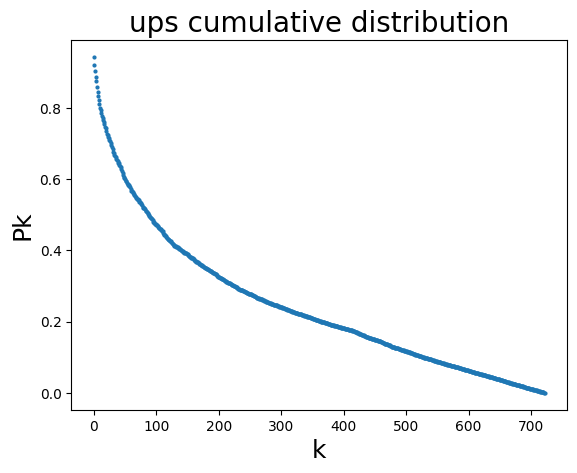

In [6]:
# Plot ups distribution
import numpy as np
ups = np.squeeze(np.array(final_df["ups"]+1))
k = np.unique(ups)
pk = np.histogram(ups,k)[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(Pk,'o', markersize=2)
plt.title("ups cumulative distribution", size=20)
plt.xlabel("k", size=18)
plt.ylabel("Pk", size=18)
plt.show()

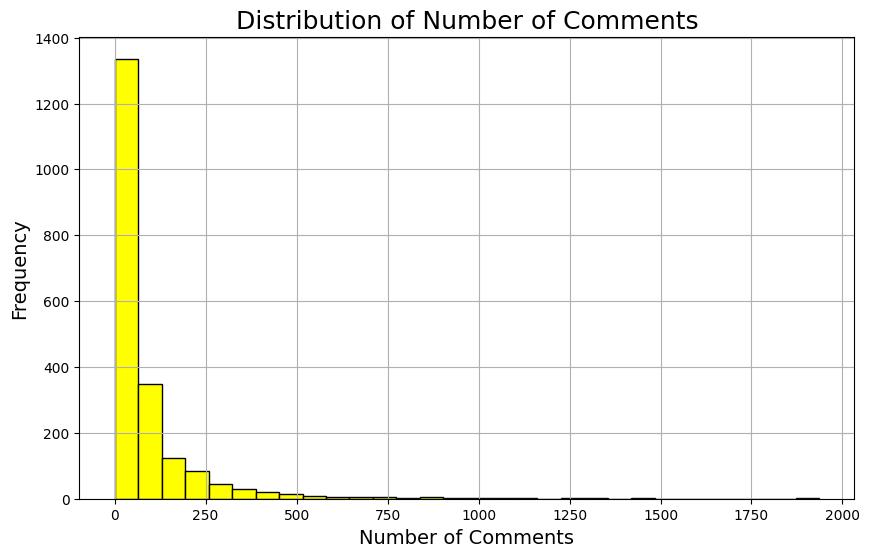

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(final_df["num_comments"], bins=30, color='yellow', edgecolor='black')
plt.title("Distribution of Number of Comments", size=18)
plt.xlabel("Number of Comments", size=14)
plt.ylabel("Frequency", size=14)
plt.grid(True)
plt.show()

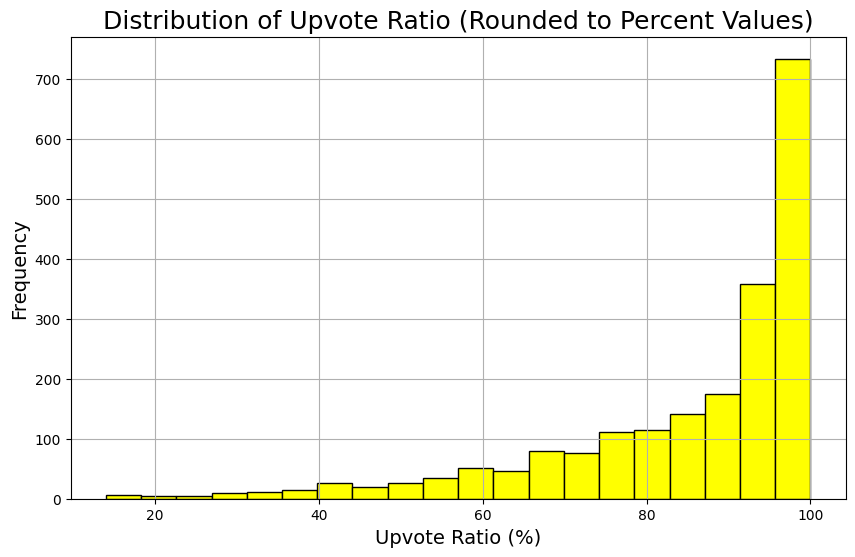

In [8]:
# Rounding upvote ratio to percent values
final_df["upvote_ratio_percent"] = (final_df["upvote_ratio"] * 100).round()

# Plotting the distribution of the rounded upvote ratio
plt.figure(figsize=(10, 6))
plt.hist(final_df["upvote_ratio_percent"], bins=20, color='yellow', edgecolor='black')
plt.title("Distribution of Upvote Ratio (Rounded to Percent Values)", size=18)
plt.xlabel("Upvote Ratio (%)", size=14)
plt.ylabel("Frequency", size=14)
plt.grid(True)
plt.show()

In [ ]:
# Filtering the dataframe, keeping the posts that have more than 200 ups
final_df_selected = final_df.copy()
final_df_selected = final_df_selected.loc[final_df_selected['ups'] >=200]
display(final_df_selected)

,id,created,subreddit,title,selftext,author,author_fullname,upvote_ratio,ups,num_comments,upvote_ratio_percent
13,157ktz0,2023-07-23,TwoXChromosomes,To the men who understand feminism after seein...,Don’t post about it here. We know what issues ...,tiny_galaxies,t2_6h06qwsz,0.67,7998,1259,67.0
14,1cyevrl,2024-05-22,TwoXChromosomes,"As a Flight Attendant, it’s depressing seeing ...",With the summer travel season here I would lik...,yunghazel,t2_o5jiopc,0.83,7934,890,83.0
15,1do4pqd,2024-06-25,TwoXChromosomes,PSA: There's a 'transvestigating' movement hap...,"These past few days, I keep seeing posts from ...",Actual-Molasses7608,t2_1209yw3nzg,0.86,4810,760,86.0
16,1bjddvn,2024-03-20,TwoXChromosomes,I went through a nightmare… with the guy I wat...,"He seemed normal, from a loving family. I, on ...",nnmm77,t2_icprc5i3,0.86,3586,411,86.0
17,19e44qk,2024-01-24,TwoXChromosomes,What am I not getting about Barbie?,I’ve watched Barbie twice now and I can’t unde...,Inevitable_Bit_9257,t2_8ntwf80f,0.82,3493,701,82.0
...,...,...,...,...,...,...,...,...,...,...,...
1780,1cixfuc,2024-05-03,LeftWingMaleAdvocates,Feminist Spaces Frequently Encourage Hateful o...,[There is a Medium article](https://medium.com...,Enticing_Venom,t2_9jlg31hs,0.98,260,35,98.0
1781,1ax2xsk,2024-02-22,LeftWingMaleAdvocates,So I went to Ask Feminists… It wasn’t that bad,"Just had to get that out of the way, I found i...",Fallen-Shadow-1214,t2_uhd7tcheo,0.93,248,240,93.0
1782,1ag69b9,2024-02-01,LeftWingMaleAdvocates,Gen Z boys and men more likely than baby boome...,,Fan_Service_3703,t2_s3sgfh6j,0.98,244,94,98.0
1783,1d0k5j7,2024-05-25,LeftWingMaleAdvocates,Why are so many Feminist statistics accepted w...,"As an example, the whole idea that false rape ...",Low-Philosopher-2354,t2_yvx9s29f2,0.98,215,60,98.0


Extract comments

In [ ]:


# Defining a function to extract comments from a list of post IDs
def extract_comments(post_id_list):

    all_comments = []

    # Loop through each post ID in the provided list
    for i in range(len(post_id_list)):

        try:
            post_id = post_id_list[i]
            submission = reddit.submission(id=post_id)
            submission.comments.replace_more(limit=None)
            collected_comments = list(submission.comments)
            all_comments.extend(collected_comments)
            print(f"Downloaded {len(collected_comments)} comments for post number {i}, id = {post_id}")

        except Exception as error:
            print(f"Rate limit exceeded. Waiting for a moment. Error: {error}")
            time.sleep(7)
            continue

    # Convert the list of comments into a DataFrame
    df = pd.DataFrame(vars(post) for post in all_comments)
    print('a total of ' + str(len(df)) + ' comments have been retrieved')
    return df



In [ ]:
# Extract comments from the selected posts
comments_df = extract_comments(list(final_df_selected['id']))

# Filter the DataFrame to keep only the columns that are useful
comments_df = comments_df[['id','parent_id','created','subreddit','body',
         'author','author_fullname','ups','downs']]

# Convert timestamp to a readable format
comments_df["created"] = [datetime.date.fromtimestamp(i) for i in comments_df["created"]]



Downloaded 150 comments for post number 0, id = 157ktz0
Downloaded 292 comments for post number 1, id = 1cyevrl
Downloaded 227 comments for post number 2, id = 1do4pqd
Downloaded 127 comments for post number 3, id = 1bjddvn
Downloaded 322 comments for post number 4, id = 19e44qk
Downloaded 42 comments for post number 5, id = 15i9fr5
Downloaded 130 comments for post number 6, id = 1cke27t
Downloaded 26 comments for post number 7, id = 18mrhfs
Downloaded 124 comments for post number 8, id = 16twiw3
Downloaded 311 comments for post number 9, id = 16mm83n
Downloaded 142 comments for post number 10, id = 1d36lhg
Downloaded 70 comments for post number 11, id = 1bzg9ms
Downloaded 628 comments for post number 12, id = 1848yxz
Downloaded 61 comments for post number 13, id = 1ag4l1z
Downloaded 124 comments for post number 14, id = 1abqo5q
Downloaded 31 comments for post number 15, id = 1daeqtq
Downloaded 345 comments for post number 16, id = 173z9jr
Downloaded 72 comments for post number 17, id 

Downloaded 147 comments for post number 51, id = 1auuhlb
Downloaded 76 comments for post number 52, id = 1bvg1jx
Downloaded 113 comments for post number 53, id = 1axl71h
Rate limit exceeded. Waiting for a moment. Error: received 429 HTTP response
Downloaded 67 comments for post number 55, id = 1cpg354
Downloaded 36 comments for post number 56, id = 1bkz4z0
Downloaded 36 comments for post number 57, id = 1df6slg
Downloaded 79 comments for post number 58, id = 1c4fjg5
Downloaded 160 comments for post number 59, id = 1c52725
Downloaded 81 comments for post number 60, id = 15ahn57
Downloaded 31 comments for post number 61, id = 1cz3oh0
Downloaded 40 comments for post number 62, id = 1amq2n2
Downloaded 30 comments for post number 63, id = 18fzf7k
Downloaded 23 comments for post number 64, id = 1790upr
Downloaded 23 comments for post number 65, id = 1ako3ax
Downloaded 21 comments for post number 66, id = 1b9tcoe
Downloaded 9 comments for post number 67, id = 15opmol
Downloaded 37 comments fo

Downloaded 172 comments for post number 554, id = 1cjyojw
Downloaded 36 comments for post number 555, id = 1cxh8ss
Downloaded 130 comments for post number 556, id = 16ntyxw
Downloaded 87 comments for post number 557, id = 15sv9fe
Downloaded 50 comments for post number 558, id = 18n7ovv
Downloaded 49 comments for post number 559, id = 1clj7sw
Downloaded 34 comments for post number 560, id = 169j392
Downloaded 29 comments for post number 561, id = 1ciot92
Downloaded 107 comments for post number 562, id = 19ce3qf
Downloaded 33 comments for post number 563, id = 18lfvoq
Downloaded 76 comments for post number 564, id = 1auw3hi
Downloaded 41 comments for post number 565, id = 1d2phja
Downloaded 25 comments for post number 566, id = 1cpf6rb
Downloaded 97 comments for post number 567, id = 1budjgv
Downloaded 47 comments for post number 568, id = 1ckyyf2
Downloaded 100 comments for post number 569, id = 1arylv4
Downloaded 33 comments for post number 570, id = 15vmi69
Downloaded 126 comments for

OSError: Cannot save file into a non-existent directory: 'drive/MyDrive/NetworkScience_Project/Reddit'

In [ ]:
# Save the filtered and processed comments DataFrame to a CSV file
comments_df.to_csv('/content/drive/MyDrive/Network_science/feminism2_reddit.csv', index=True)

# Display the processed comments DataFrame
display(comments_df)

,id,parent_id,created,subreddit,body,author,author_fullname,ups,downs
0,jt9881s,t3_157ktz0,2023-07-24,TwoXChromosomes,This post sure got a lot of reports. \n\nWhat ...,Perodis,t2_ehlbe,1,0
1,jt5rhb9,t3_157ktz0,2023-07-23,TwoXChromosomes,"Just saying, the concept of men suddenly appre...",mike0sd,t2_mnf98,5188,0
2,jt65tgs,t3_157ktz0,2023-07-23,TwoXChromosomes,It pissed off Ben Shapiro. I may see this movi...,Ness_of_Onett,t2_10lj8t,284,0
3,jt5itpq,t3_157ktz0,2023-07-23,TwoXChromosomes,[Relevant SNL](https://youtu.be/42_fVUFsN8M),Toidal,t2_40n1f,866,0
4,jt738ib,t3_157ktz0,2023-07-24,TwoXChromosomes,Any man who watched the Barbie movie and thoug...,The_Young_Busac,t2_xau9p,132,0
...,...,...,...,...,...,...,...,...,...
29196,kp4e9q0,t3_1ainrnn,2024-02-06,LeftWingMaleAdvocates,>“There was a collective raising awareness of ...,Clemicus,t2_8jt9n,5,0
29197,kpanb01,t3_1ainrnn,2024-02-07,LeftWingMaleAdvocates,People need to stop talking about masculinity....,None,NaN,5,0
29198,kp456i4,t3_1ainrnn,2024-02-06,LeftWingMaleAdvocates,Men are going their own way because no sane se...,traveller1976,t2_l42m0,7,0
29199,kp2qrvp,t3_1ainrnn,2024-02-05,LeftWingMaleAdvocates,"Well, when a major position is that men are ev...",General_Alduin,t2_55xkvi72,5,0


In [2]:
%run "/content/drive/MyDrive/Network_science/Functions.ipynb"

bertopic 1.11
softlouvain v1.10


In [10]:
df = pd.read_csv("/content/drive/MyDrive/Network_science/feminism_reddit.csv")
df = df[["id","created","title"]] # we only keep a few meaningful entries
display(df)


# Perform initial cleaning on the title column to remove basic noise
df['text_sup_clean'] = df['title'].apply(superficial_cleaning)

# Perform Deep cleaning
POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB","NUM"] # we do not include "PRON"
df['text_deep_clean'] = df['text_sup_clean'].apply(deep_cleaning)
df['text_deep_clean_pos'] = df['text_sup_clean'].apply(deep_cleaning_pos)

# Identify and extract any hashtags from the 'title' column
df['hashtags'] = df['title'].apply(get_hashtags)

# Display the result
display(df)

,id,created,title
0,14wo2z8,2023-07-11,What's the diference betwew toxic masculinity ...
1,14vb4ek,2023-07-09,What are the best books on the subject of Femi...
2,1525llh,2023-07-17,Who defines what Masculinity and Feminity is?
3,157g9ox,2023-07-23,do you consider yourself a feminist and what d...
4,1cokdwc,2024-05-10,Why feminism is called this way?
...,...,...,...
2038,1bzdls3,2024-04-08,Research on the impacts of the '#Girlboss' mov...
2039,17xgcjj,2023-11-17,I'd like to vent about how some movements nega...
2040,1510yt8,2023-07-16,What Is Feminism? | Gynocentrism and its Cultu...
2041,16d9pd1,2023-09-08,The Two Faces of Feminism: Grandiose and vulne...


<ipython-input-9-00537011d083>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(selftext, "html.parser")


,id,created,title,text_sup_clean,text_deep_clean,text_deep_clean_pos,hashtags
0,14wo2z8,2023-07-11,What's the diference betwew toxic masculinity ...,what is the diference betwew toxic masculinity...,diference betwew toxic masculinity toxic feminity,"[diference NOUN, betwew PROPN, toxic ADJ, masc...",[]
1,14vb4ek,2023-07-09,What are the best books on the subject of Femi...,what are the best books on the subject of femi...,good book subject feminism man read,"[good ADJ, book NOUN, subject NOUN, feminism N...",[]
2,1525llh,2023-07-17,Who defines what Masculinity and Feminity is?,who defines what masculinity and feminity is,define masculinity feminity,"[define VERB, masculinity NOUN, feminity NOUN]",[]
3,157g9ox,2023-07-23,do you consider yourself a feminist and what d...,do you consider yourself a feminist and what d...,consider feminist feminism mean,"[consider VERB, feminist NOUN, feminism NOUN, ...",[]
4,1cokdwc,2024-05-10,Why feminism is called this way?,why feminism is called this way,feminism way,"[feminism NOUN, call VERB, way NOUN]",[]
...,...,...,...,...,...,...,...
2038,1bzdls3,2024-04-08,Research on the impacts of the '#Girlboss' mov...,research on the impacts of the movement on soc...,research impact movement societal perception f...,"[research NOUN, impact NOUN, movement NOUN, so...",[girlboss]
2039,17xgcjj,2023-11-17,I'd like to vent about how some movements nega...,i would like to vent about how some movements ...,like vent movement negatively affect feminism,"[like VERB, vent VERB, movement NOUN, negative...",[]
2040,1510yt8,2023-07-16,What Is Feminism? | Gynocentrism and its Cultu...,what is feminism gynocentrism and its cultural...,feminism gynocentrism cultural origin,"[feminism NOUN, gynocentrism NOUN, cultural AD...",[]
2041,16d9pd1,2023-09-08,The Two Faces of Feminism: Grandiose and vulne...,the two faces of feminism grandiose and vulner...,face feminism grandiose vulnerable,"[two NUM, face NOUN, feminism NOUN, grandiose ...",[]


In [ ]:
# Perform initial cleaning on the title column to remove basic noise
df['text_sup_clean'] = df['title'].apply(superficial_cleaning)

# Perform Deep cleaning
POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB","NUM"] # we do not include "PRON"
df['text_deep_clean'] = df['text_sup_clean'].apply(deep_cleaning)
df['text_deep_clean_pos'] = df['text_sup_clean'].apply(deep_cleaning_pos)

# Identify and extract any hashtags from the 'title' column
df['hashtags'] = df['title'].apply(get_hashtags)

# Display the result
display(df)

<ipython-input-14-00537011d083>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(selftext, "html.parser")


,id,created,title,text_sup_clean,text_deep_clean,text_deep_clean_pos,hashtags
0,14wo2z8,2023-07-11,What's the diference betwew toxic masculinity ...,what is the diference betwew toxic masculinity...,diference betwew toxic masculinity toxic feminity,"[diference NOUN, betwew PROPN, toxic ADJ, masc...",[]
1,14vb4ek,2023-07-09,What are the best books on the subject of Femi...,what are the best books on the subject of femi...,good book subject feminism man read,"[good ADJ, book NOUN, subject NOUN, feminism N...",[]
2,1525llh,2023-07-17,Who defines what Masculinity and Feminity is?,who defines what masculinity and feminity is,define masculinity feminity,"[define VERB, masculinity NOUN, feminity NOUN]",[]
3,157g9ox,2023-07-23,do you consider yourself a feminist and what d...,do you consider yourself a feminist and what d...,consider feminist feminism mean,"[consider VERB, feminist NOUN, feminism NOUN, ...",[]
4,1cokdwc,2024-05-10,Why feminism is called this way?,why feminism is called this way,feminism way,"[feminism NOUN, call VERB, way NOUN]",[]
...,...,...,...,...,...,...,...
2043,1bzdls3,2024-04-08,Research on the impacts of the '#Girlboss' mov...,research on the impacts of the movement on soc...,research impact movement societal perception f...,"[research NOUN, impact NOUN, movement NOUN, so...",[girlboss]
2044,17xgcjj,2023-11-17,I'd like to vent about how some movements nega...,i would like to vent about how some movements ...,like vent movement negatively affect feminism,"[like VERB, vent VERB, movement NOUN, negative...",[]
2045,1510yt8,2023-07-16,What Is Feminism? | Gynocentrism and its Cultu...,what is feminism gynocentrism and its cultural...,feminism gynocentrism cultural origin,"[feminism NOUN, gynocentrism NOUN, cultural AD...",[]
2046,16d9pd1,2023-09-08,The Two Faces of Feminism: Grandiose and vulne...,the two faces of feminism grandiose and vulner...,face feminism grandiose vulnerable,"[two NUM, face NOUN, feminism NOUN, grandiose ...",[]


In [12]:
# Define a cutoff date to filter dataframe entries
mask = '2023-07-21'

# Select rows in the dataframe
df_before = df[df['created']< mask]
df_before = df_before.reset_index(drop=True)

# Display the result
display(df_before)

,id,created,title,text_sup_clean,text_deep_clean,text_deep_clean_pos,hashtags
0,14wo2z8,2023-07-11,What's the diference betwew toxic masculinity ...,what is the diference betwew toxic masculinity...,diference betwew toxic masculinity toxic feminity,"[diference NOUN, betwew PROPN, toxic ADJ, masc...",[]
1,14vb4ek,2023-07-09,What are the best books on the subject of Femi...,what are the best books on the subject of femi...,good book subject feminism man read,"[good ADJ, book NOUN, subject NOUN, feminism N...",[]
2,1525llh,2023-07-17,Who defines what Masculinity and Feminity is?,who defines what masculinity and feminity is,define masculinity feminity,"[define VERB, masculinity NOUN, feminity NOUN]",[]
3,14w3hkd,2023-07-10,My bf just told me my feelings are less import...,my bf just told me my feelings are less import...,bf tell feeling important people feeling,"[bf NOUN, just ADV, tell VERB, feeling NOUN, l...",[]
4,14uf8va,2023-07-08,Revenge Fantasies are Not Feminism,revenge fantasies are not feminism,revenge fantasy feminism,"[revenge NOUN, fantasy NOUN, feminism NOUN]",[]
...,...,...,...,...,...,...,...
91,14vem2r,2023-07-10,what books on Feminism should a man read?,what books on feminism should a man read,book feminism man read,"[book NOUN, feminism NOUN, man NOUN, read VERB]",[]
92,152tv7e,2023-07-18,Major voice of the second-wave feminism Germai...,major voice of the second wave feminism germai...,major voice second wave feminism germaine gree...,"[major ADJ, voice NOUN, second ADJ, wave NOUN,...",[]
93,14vbqed,2023-07-09,Founder of Everyday Feminism Sandra Kim offer ...,founder of everyday feminism sandra kim offer ...,founder everyday feminism sandra kim offer cou...,"[founder NOUN, everyday ADJ, feminism NOUN, sa...",[]
94,1510yt8,2023-07-16,What Is Feminism? | Gynocentrism and its Cultu...,what is feminism gynocentrism and its cultural...,feminism gynocentrism cultural origin,"[feminism NOUN, gynocentrism NOUN, cultural AD...",[]


In [ ]:
out_dir = "/content/drive/MyDrive/Network_science/"
out_file = "final_feminism_reddit_"

df_before.to_excel(out_dir+out_file+"before_cleaned.xlsx", index=True)

In [ ]:
# Create a unique collection of words
words_before = np.unique([item for sublist in df_before['text_deep_clean_pos'] for item in sublist])
# Create a dictionary where each unique word is mapped to a unique integer.
words_dict_before = dict(zip(words_before,range(len(words_before))))
# Initialize an occurrence matrix
Mwd_before = csr_matrix((len(words_dict_before), len(df_before)), dtype = np.int8).toarray()
for i in range(len(df_before)):
  for j in df_before['text_deep_clean_pos'][i]:
    Mwd_before[words_dict_before[j],i] += 1

In [ ]:
# Collect a unique set of hashtags from the 'hashtags' column
hashtags_before = np.unique([item for sublist in df_before['hashtags'] for item in sublist])
# Prepend the hash (#) symbol to each hashtag
hashtags2_before = np.unique(["#"+item for sublist in df_before['hashtags'] for item in sublist])
# Create a dictionary mapping each unique hashtag to a unique integer
hashtags_dict_before = dict(zip(hashtags_before,range(len(hashtags_before))))
# Initialize an occurrence matrix
Mhd_before = csr_matrix((len(hashtags_dict_before), len(df_before)), dtype = np.int8).toarray()
for i in range(len(df_before)):
  for j in df_before['hashtags'][i]:
    Mhd_before[hashtags_dict_before[j],i] += 1

In [ ]:
# Combine words and hashtags
Mwd_before = np.vstack((Mwd_before, Mhd_before))
words_before = np.hstack((words_before, hashtags2_before))
documents_before = np.array(df_before["id"].tolist())

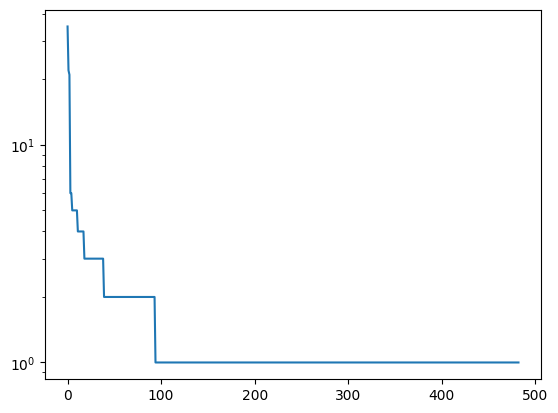

In [ ]:
# Plot the distribution of word occurrences in the 'before' dataset.
plt.figure()
plt.semilogy(-np.sort(-np.sum(Mwd_before,axis=1)))
plt.savefig(out_dir+out_file+"_statistics_before.png")

In [ ]:
# Filter out words with low occurrence
select_before = (np.sum(Mwd_before,axis=1)>2)
Mwd_before = Mwd_before[select_before,:]
words_before = words_before[select_before]
# Filter out documents that do not contain words
select_before = (np.sum(Mwd_before,axis=0)>0)
Mwd_before = Mwd_before[:,select_before]
documents_before = documents_before[select_before]
# Display the shape of the final word occurrence matrix after filtering
display(Mwd_before.shape)

(39, 86)

In [ ]:
# Save the result
pickle.dump([Mwd_before,words_before,documents_before], open(out_dir+out_file+"_before_occurrences.p", "wb"))
# c,d,e = pickle.load(open(out_dir+out_file+"_occurrences.p","rb"))

In [33]:
!pip install bertopic
from bertopic import BERTopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 6.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB

KeyboardInterrupt: 

In [ ]:
in_dir = "/content/drive/MyDrive/Network_science/"
in_file = "final_feminism_reddit__before"

# Load the serialized word occurrence data
Mwd, words, documents = pickle.load(open(in_dir+in_file+"_occurrences.p","rb"))
Mwd = sps.csr_matrix(Mwd)

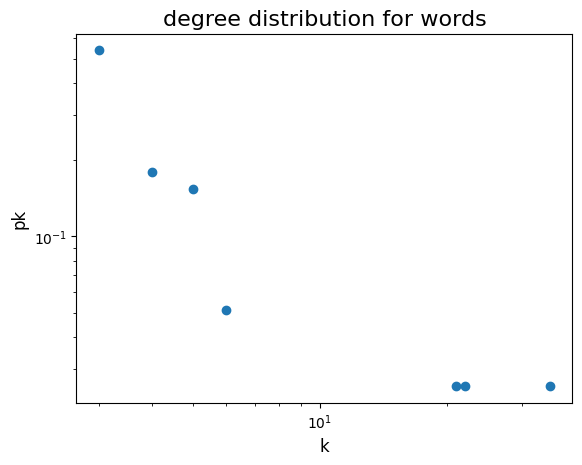

In [ ]:
# Calculate the degree distribution for words within the word occurrence matrix
dw = np.squeeze(np.asarray(Mwd.sum(axis=1))) # words degrees
k = np.unique(dw)
pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()
plt.loglog(k,pk,'o')
plt.title("degree distribution for words", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()


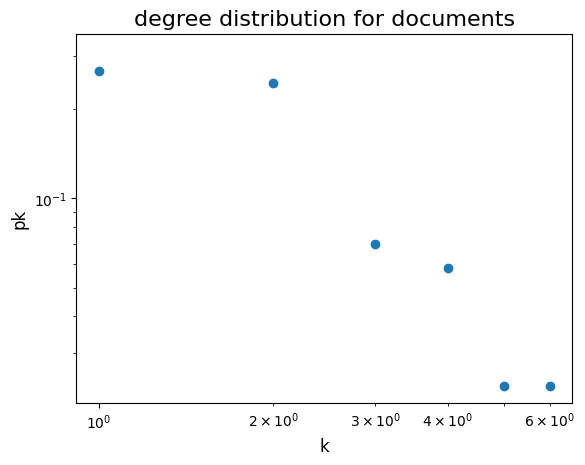

In [ ]:
# Calculate the degree distribution for documents within the word occurrence matrix
dd = np.squeeze(np.asarray(Mwd.sum(axis=0))) # documents degrees
k = np.unique(dd)
pk = np.histogram(dd,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()
plt.loglog(pk,'o')
plt.title("degree distribution for documents", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()

In [ ]:
# Remove elements that are excessively central
Mwd, words, documents = clean_Mwd_matrix(Mwd,words,documents)
# Construct probability matrices
Pwd, Pww, Pdd, Paa = probability_matrices(Mwd, tform=False)

removing: feminism NOUN man NOUN really ADV want VERB 


In [ ]:
# Start a timer to measure the execution time
tic = time.time()

# Generate a graph from the document-document probability matrix
A = sps.csr_matrix(Pdd)
G = ig.Graph.Adjacency((A > 0).toarray().tolist())
G.es['weight'] = np.array(A[A.nonzero()])[0]

# Apply the Louvain algorithm to the graph for community detection
part = louvain.find_partition(G, louvain.ModularityVertexPartition,
                                 weights='weight')

# Define a function to convert the Louvain partitioning result into a community assignment matrix (C)
def partition_to_C(part):
  C = sps.csr_matrix((Pdd.shape[0],len(part)))
  for i in range(len(part)):
    C[np.array(part[i]),i] = 1
  return C

# Convert the Louvain partition into a community assignment matrix
C_l = partition_to_C(part)

# Record the time taken to perform the initial Louvain
et_louv = time.time()-tic

# Apply a refinement step with a 'soft' Louvain algorithm variant
C_sl, _, _ = my_soft_louvain(Pdd, C_l)

# Record the total execution time
et_slouv = time.time()-tic

[41, 41]
1.4142135623730951
1.4142135623730951
0.0
[41, 8]
0.0


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
# Load the cleaned text data
df2 = pd.read_excel("/content/drive/MyDrive/Network_science/final_feminism_reddit_before_cleaned.xlsx")
df2["id"] = np.array([str(i) for i in df2["id"]])

# Filter 'df2' to include only those documents that are present in the community assignment matrix 'Pcc'
documents = np.array([str(i) for i in documents])
df2 = df2.loc[df2['id'].isin(documents)]
df2.index = np.array(range(len(df2)))

# Reinsert hashtags into the cleaned text
df2["text_deep_clean2"] = [str(df2["text_deep_clean"][i]) + " #" +
                           df2["hashtags"][i][2:-2].replace("', '"," #")
                           for i in range(len(df2))]

In [ ]:
# Start a timer to measure the execution time for topic modeling with BERTopic
tic = time.time()

# Initialize a BERTopic instance for topic modeling
bert_model = BERTopic()

# Perform topic modeling on the documents using BERTopic
docs = list(df2["title"])
topics, probabilities = bert_model.fit_transform(docs)

# Define a function to convert the topic assignments into a community assignment matrix
def topics_to_C(topics):
  # extract community assignments
  C = sps.csr_matrix((len(topics),max(topics)+2))
  for i in range(C.shape[1]):
    C[np.array(topics)==(i-1),i] = 1
  # remove zero assignments
  C = C[:,np.unique(scipy.sparse.find(C)[1])]
  return C

# Convert the list of topic assignments into a community assignment
C_b = topics_to_C(topics)

# Calculate and capture the execution time
et_bert = time.time()-tic

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
# Initialize a DataFrame
df = pd.DataFrame(data={'data':[],'algo':[],'time':[],'c#':[],
                        'NMI':[],'Q':[],'Ncut':[],'InfoMap':[]})

# Compute the Infomap ranking vector 'r'
r = infomap_rank(Pdd)


In [ ]:
# Evaluate clustering performance metrics for the hard Louvain method
stats = clustering_statistics(C_l,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"hard Louvain Pdd",et_louv,C_l.shape[1]] + stats

# Evaluate clustering performance metrics for the soft Louvain method
stats = clustering_statistics(C_sl,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"soft Louvain Pdd",et_slouv,C_sl.shape[1]] + stats

# Evaluate clustering performance metrics for the hard BERTopic method
stats = clustering_statistics(C_b,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"BERTopic",et_bert,C_b.shape[1]] + stats


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
<ipython-input-2-a0eeac66ccd8>:7: RuntimeWarning: divide by zero encountered in scalar divide
  y = (A.multiply(A2)).sum()/Hc
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
# Display the result
display(df)

,data,algo,time,c#,NMI,Q,Ncut,InfoMap
0,final_feminism_reddit__before,hard Louvain Pdd,0.020113,8,0.767669,5.929801e-01,0.274256,-1.411210e-01
1,final_feminism_reddit__before,soft Louvain Pdd,0.139526,8,0.769084,5.951861e-01,0.269923,-1.428266e-01
2,final_feminism_reddit__before,BERTopic,20.827767,1,-inf,-4.440892e-16,0.000000,2.442491e-15


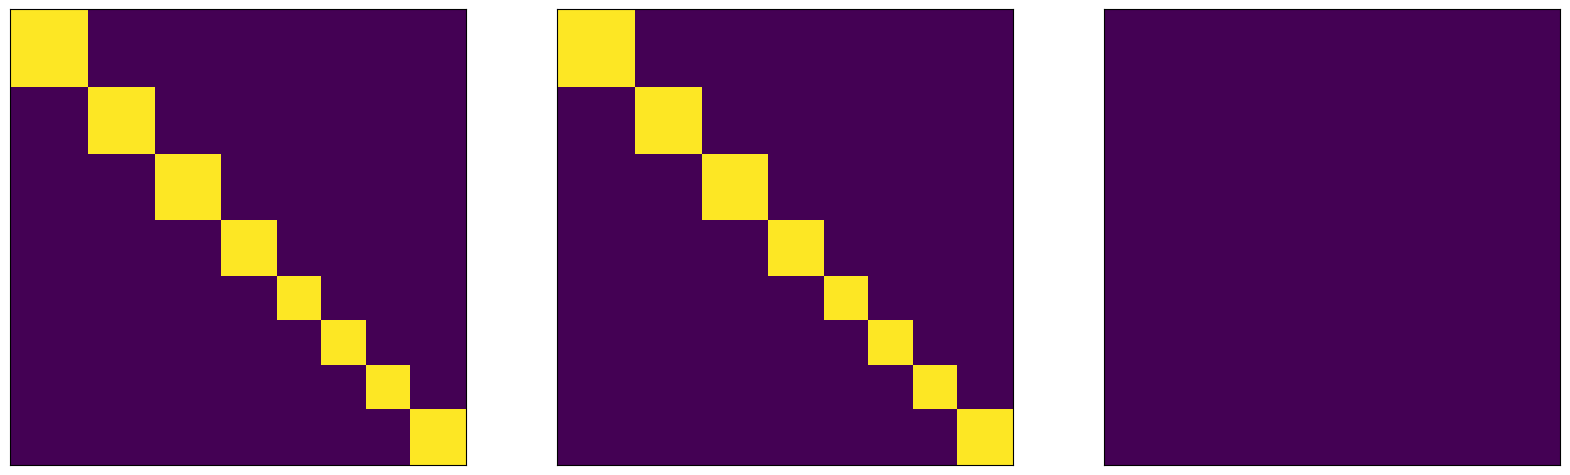

In [ ]:
#  Visualize the community structures
plot_community_patterns([C_l,C_sl,C_b],nrows=1,ncols=3,refs=[0,2])

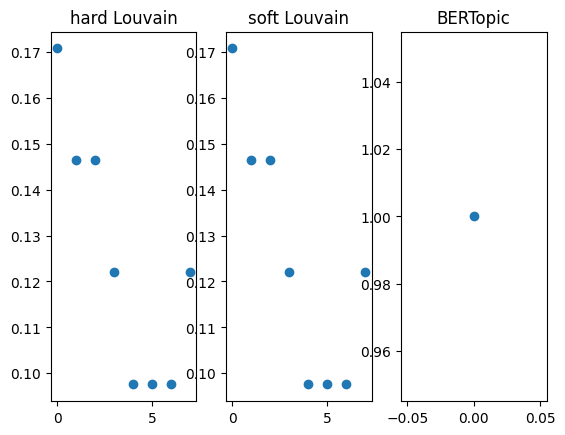

In [ ]:
# visualizes the distribution of documents across communities
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(C_l.sum(axis=0))[0]/C_l.sum(),'o')
ax1.set_title('hard Louvain')
ax2.plot(np.array(C_sl.sum(axis=0))[0]/C_sl.sum(),'o')
ax2.set_title('soft Louvain')
ax3.plot(np.array(C_b.sum(axis=0))[0]/C_b.sum(),'o')
ax3.set_title('BERTopic');

In [ ]:
# Initialize a BERTopic model customized for the communities identified by Louvain
docs = list(df2["text_deep_clean2"])
bert_model1 = bertopic_overwrite(bert_model,docs,C_l)

# Visualize the top words for each topic (community) identified
bert_model1.visualize_barchart(topics = range(C_l.shape[1]),
                               n_words = 8,
                               title = "Louvain results")

In [ ]:
# BERTopic second

# use the clean text in order to get a more meaningful description
docs = list(df2["text_deep_clean2"])
bert_model2 = bertopic_overwrite(bert_model,docs,C_b)

# visualize topic description
bert_model2.visualize_barchart(topics = range(C_b.shape[1]),
                               n_words = 8,
                               title = "BERTopic results")

In [ ]:
topics = bert_model1.get_topics()
print(topics)

{0: [('abortion', 0.11963197013225864), ('use', 0.11963197013225864), ('hate', 0.10803941955600001), ('woman', 0.0992382060002543), ('definition', 0.09088389031678695), ('islam', 0.09088389031678695), ('right', 0.07975464675483909), ('victim', 0.07975464675483909), ('miscarry', 0.055169021590874195), ('misandry', 0.055169021590874195)], 1: [('support', 0.1719709570651218), ('woman', 0.14265492112536557), ('think', 0.09509926606985526), ('narrative', 0.07930546853688165), ('hateful', 0.07930546853688165), ('induce', 0.07930546853688165), ('downvote', 0.07930546853688165), ('hospital', 0.07930546853688165), ('drinkst', 0.07930546853688165), ('commenter', 0.07930546853688165)], 2: [('wife', 0.10451647386430499), ('housework', 0.10451647386430499), ('know', 0.10451647386430499), ('marriage', 0.10451647386430499), ('feeling', 0.10451647386430499), ('feminism', 0.06847436214017548), ('accuse', 0.06344437482950532), ('court', 0.06344437482950532), ('grant', 0.06344437482950532), ('income', 0.

In [ ]:


topics = bert_model1.get_topics()
new_df = pd.DataFrame.from_dict(topics, orient='index')

ktopics = []

for topic_list in range(0, new_df.shape[1]):
  for topic in range(0, new_df.shape[0]):
      ktopics.append(new_df[topic_list][topic][0])

unique_ktopics  = set(ktopics)
topics_ktopics = list(unique_ktopics)



In [ ]:
# Load the CSV file
df = pd.read_excel("/content/drive/MyDrive/Network_science/final_feminism_reddit_before_cleaned.xlsx")

# Extract all keywords from the BERT model's output
keywords = topics_ktopics

df["hashtags_2"] = None
for i in range(len(df["text_deep_clean"])):
  if isinstance(df["text_deep_clean"][i], str):  # Check if text is a string
    hashtags2 = []

    for word in df["text_deep_clean"][i].split():

      if word in keywords:
        #  print(type(word))
          hashtags2.append(str(word))
          df["hashtags_2"][i] = hashtags2



In [ ]:


df.to_pickle('/content/drive/MyDrive/Network_science/final_feminism_reddit_before_cleaned.pkl')


comments_df = pd.read_pickle("/content/drive/MyDrive/Network_science/final_feminism_reddit_before_cleaned.pkl")


comments_filtered = comments_df.copy()
column_list = ["id","created", "text_deep_clean", "text_deep_clean_pos", "hashtags_2"]
comments_filtered = comments_filtered[column_list]



In [ ]:
#initialize an empty dict
unique_words = {}
for row in comments_filtered["text_deep_clean"]:
    if pd.notna(row):
        # Split the row into words and iterate over them
        for word in row.split(" "):
            #if the word is encountered for the first time add to dict as key and set its value to 0
            unique_words.setdefault(word,0)
            #increase the value (i.e the count) of the word by 1 every time it is encountered
            unique_words[word] += 1

In [ ]:
uw_df = pd.DataFrame.from_dict(unique_words, orient='index').reset_index()
uw_df.rename(columns = {'index':'Word', 0:'Count'}, inplace=True)
uw_df.sort_values(by=['Count'], ascending=False, inplace=True)
uw_df

,Word,Count
8,feminism,37
9,man,22
92,woman,21
144,feminist,10
171,right,6
...,...,...
166,assault,1
165,imply,1
164,consensual,1
163,venerate,1


In [ ]:
!pip install wordcloud matplotlib
from wordcloud import WordCloud

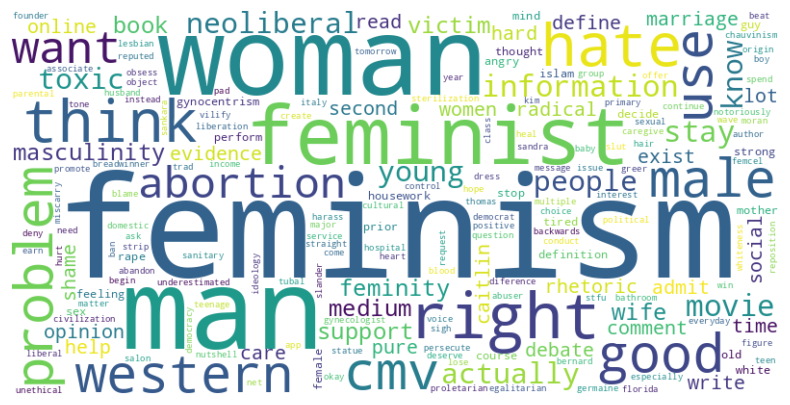

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(uw_df.set_index('Word').to_dict()['Count'])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
unique_hashtags = {}


for idx, row in comments_filtered.iterrows():
  hashtag_list = []
  try:
    for hashtag in row["hashtags_2"]:
      unique_hashtags.setdefault("#"+hashtag, 0)
      unique_hashtags['#'+hashtag] += 1
      hashtag_list.append(hashtag)
  except:
      continue

In [ ]:


uh_df = pd.DataFrame.from_dict(unique_hashtags, orient='index').reset_index()
uh_df.rename(columns = {'index':'Hashtag', 0:'Count'}, inplace=True)
uh_df.sort_values(by=['Count'], ascending=False, inplace=True)



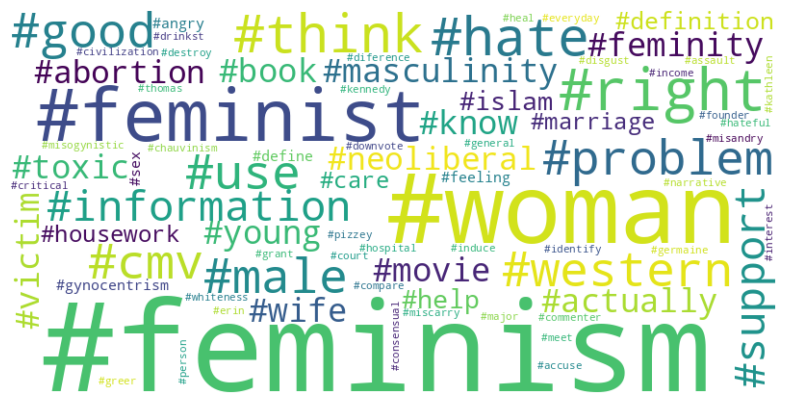

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(uh_df.set_index('Hashtag').to_dict()['Count'])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Building Network

In [ ]:
import itertools
import networkx as nx


uh = unique_hashtags.keys()
uw = unique_words.keys()

In [ ]:
network = {}
for index, row in comments_filtered.iterrows():
    combined_list = row['hashtags_2']  # Use keys() to get the list of unique subreddits
    if isinstance(combined_list, list):
      for pair in itertools.product(combined_list, combined_list):
          if pair[0] != pair[1] and not (pair[::-1] in network):
              #breakpoint()
              network.setdefault(pair, 0)
              # Update the weight based on actual occurrences
              network[pair] += 1

network_df = pd.DataFrame.from_dict(network, orient="index")

In [ ]:
network_df.reset_index(inplace=True)
network_df.columns = ["pair","weight"]
network_df.sort_values(by="weight",inplace=True, ascending=False)
network_df

,pair,weight
120,"(support, woman)",6
73,"(feminism, feminist)",6
66,"(feminism, problem)",5
91,"(right, feminism)",4
70,"(problem, care)",4
...,...,...
83,"(feminist, victim)",1
84,"(male, victim)",1
85,"(accuse, wife)",1
86,"(accuse, court)",1


In [ ]:
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted = []
for edge in network:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted.append((edge[0],edge[1],network[edge]))

G = nx.Graph()
G.add_weighted_edges_from(up_weighted)

In [ ]:
print(len(G.nodes()))
print(len(G.edges()))

75
211


In [ ]:
filename = "/content/drive/MyDrive/Network_science/feminism_edgelist_before_released.csv"

nx.write_weighted_edgelist(G, filename, delimiter=",")


In [ ]:
word_nodes = pd.DataFrame.from_dict(unique_words,orient="index")
word_nodes.reset_index(inplace=True)
word_nodes["Label"] = word_nodes["index"]
word_nodes.rename(columns={"index":"Id",0:"delete"},inplace=True)
word_nodes = word_nodes.drop(columns=['delete'])

In [ ]:
hashtag_nodes = uh_df.copy()
hashtag_nodes["Label"] = hashtag_nodes["Hashtag"]
hashtag_nodes.rename(columns={"Hashtag":"Id"},inplace=True)
hashtag_nodes = hashtag_nodes.drop(columns=['Count'])



In [ ]:
nodelist = hashtag_nodes
nodelist.to_csv("/content/drive/MyDrive/Network_science/feminism_nodelist_before_released.csv",index=False)


a = pd.read_csv("/content/drive/MyDrive/Network_science/feminism_edgelist_before_released.csv")


a.columns = ['Source','Target','Label']


a.to_csv("/content/drive/MyDrive/Network_science/feminism_edgelist_before_released.csv",index=False)



# Femminism Discussion After Barbie

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Network_science/feminism_reddit.csv")
df = df[["id","created","title"]] # we only keep a few meaningful entries

# Perform initial cleaning on the title column to remove basic noise
df['text_sup_clean'] = df['title'].apply(superficial_cleaning)

# Perform Deep cleaning
POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB","NUM"] # we do not include "PRON"
df['text_deep_clean'] = df['text_sup_clean'].apply(deep_cleaning)
df['text_deep_clean_pos'] = df['text_sup_clean'].apply(deep_cleaning_pos)

# Identify and extract any hashtags from the 'title' column
df['hashtags'] = df['title'].apply(get_hashtags)

# Display the result
display(df)

<ipython-input-2-00537011d083>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(selftext, "html.parser")


,id,created,title,text_sup_clean,text_deep_clean,text_deep_clean_pos,hashtags
0,14wo2z8,2023-07-11,What's the diference betwew toxic masculinity ...,what is the diference betwew toxic masculinity...,diference betwew toxic masculinity toxic feminity,"[diference NOUN, betwew PROPN, toxic ADJ, masc...",[]
1,14vb4ek,2023-07-09,What are the best books on the subject of Femi...,what are the best books on the subject of femi...,good book subject feminism man read,"[good ADJ, book NOUN, subject NOUN, feminism N...",[]
2,1525llh,2023-07-17,Who defines what Masculinity and Feminity is?,who defines what masculinity and feminity is,define masculinity feminity,"[define VERB, masculinity NOUN, feminity NOUN]",[]
3,157g9ox,2023-07-23,do you consider yourself a feminist and what d...,do you consider yourself a feminist and what d...,consider feminist feminism mean,"[consider VERB, feminist NOUN, feminism NOUN, ...",[]
4,1cokdwc,2024-05-10,Why feminism is called this way?,why feminism is called this way,feminism way,"[feminism NOUN, call VERB, way NOUN]",[]
...,...,...,...,...,...,...,...
2038,1bzdls3,2024-04-08,Research on the impacts of the '#Girlboss' mov...,research on the impacts of the movement on soc...,research impact movement societal perception f...,"[research NOUN, impact NOUN, movement NOUN, so...",[girlboss]
2039,17xgcjj,2023-11-17,I'd like to vent about how some movements nega...,i would like to vent about how some movements ...,like vent movement negatively affect feminism,"[like VERB, vent VERB, movement NOUN, negative...",[]
2040,1510yt8,2023-07-16,What Is Feminism? | Gynocentrism and its Cultu...,what is feminism gynocentrism and its cultural...,feminism gynocentrism cultural origin,"[feminism NOUN, gynocentrism NOUN, cultural AD...",[]
2041,16d9pd1,2023-09-08,The Two Faces of Feminism: Grandiose and vulne...,the two faces of feminism grandiose and vulner...,face feminism grandiose vulnerable,"[two NUM, face NOUN, feminism NOUN, grandiose ...",[]


In [4]:
# Perform initial cleaning on the title column to remove basic noise
df['text_sup_clean'] = df['title'].apply(superficial_cleaning)

# Perform Deep cleaning
POS_KEEP = ["ADJ","ADV","NOUN","PROPN","VERB","NUM"] # we do not include "PRON"
df['text_deep_clean'] = df['text_sup_clean'].apply(deep_cleaning)
df['text_deep_clean_pos'] = df['text_sup_clean'].apply(deep_cleaning_pos)

# Identify and extract any hashtags from the 'title' column
df['hashtags'] = df['title'].apply(get_hashtags)

# Display the result
display(df)

<ipython-input-2-00537011d083>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(selftext, "html.parser")


,id,created,title,text_sup_clean,text_deep_clean,text_deep_clean_pos,hashtags
0,14wo2z8,2023-07-11,What's the diference betwew toxic masculinity ...,what is the diference betwew toxic masculinity...,diference betwew toxic masculinity toxic feminity,"[diference NOUN, betwew PROPN, toxic ADJ, masc...",[]
1,14vb4ek,2023-07-09,What are the best books on the subject of Femi...,what are the best books on the subject of femi...,good book subject feminism man read,"[good ADJ, book NOUN, subject NOUN, feminism N...",[]
2,1525llh,2023-07-17,Who defines what Masculinity and Feminity is?,who defines what masculinity and feminity is,define masculinity feminity,"[define VERB, masculinity NOUN, feminity NOUN]",[]
3,157g9ox,2023-07-23,do you consider yourself a feminist and what d...,do you consider yourself a feminist and what d...,consider feminist feminism mean,"[consider VERB, feminist NOUN, feminism NOUN, ...",[]
4,1cokdwc,2024-05-10,Why feminism is called this way?,why feminism is called this way,feminism way,"[feminism NOUN, call VERB, way NOUN]",[]
...,...,...,...,...,...,...,...
2038,1bzdls3,2024-04-08,Research on the impacts of the '#Girlboss' mov...,research on the impacts of the movement on soc...,research impact movement societal perception f...,"[research NOUN, impact NOUN, movement NOUN, so...",[girlboss]
2039,17xgcjj,2023-11-17,I'd like to vent about how some movements nega...,i would like to vent about how some movements ...,like vent movement negatively affect feminism,"[like VERB, vent VERB, movement NOUN, negative...",[]
2040,1510yt8,2023-07-16,What Is Feminism? | Gynocentrism and its Cultu...,what is feminism gynocentrism and its cultural...,feminism gynocentrism cultural origin,"[feminism NOUN, gynocentrism NOUN, cultural AD...",[]
2041,16d9pd1,2023-09-08,The Two Faces of Feminism: Grandiose and vulne...,the two faces of feminism grandiose and vulner...,face feminism grandiose vulnerable,"[two NUM, face NOUN, feminism NOUN, grandiose ...",[]


In [5]:
# Define a cutoff date to filter dataframe entries
mask = '2023-07-21'

# Select rows in the dataframe
df_after = df[df['created']>= mask]
df_after = df_after.reset_index(drop=True)

# Display the result
display(df_after)

,id,created,title,text_sup_clean,text_deep_clean,text_deep_clean_pos,hashtags
0,157g9ox,2023-07-23,do you consider yourself a feminist and what d...,do you consider yourself a feminist and what d...,consider feminist feminism mean,"[consider VERB, feminist NOUN, feminism NOUN, ...",[]
1,1cokdwc,2024-05-10,Why feminism is called this way?,why feminism is called this way,feminism way,"[feminism NOUN, call VERB, way NOUN]",[]
2,1aisg6n,2024-02-04,"Do you think feminism has done more good, or m...",do you think feminism has done more good or mo...,think feminism good harm,"[think VERB, feminism NOUN, do VERB, more ADV,...",[]
3,1csiepu,2024-05-15,Women embrace feminity in men so easily but vi...,women embrace feminity in men so easily but vi...,woman embrace feminity man easily vice verse d...,"[woman NOUN, embrace VERB, feminity NOUN, man ...",[]
4,17stx8a,2023-11-11,How do you flirt a man with femine energy?,how do you flirt a man with femine energy,flirt man femine energy,"[flirt VERB, man NOUN, femine NOUN, energy NOUN]",[]
...,...,...,...,...,...,...,...
1942,17bip1c,2023-10-19,"Go-to expert on ""food-based environmental femi...",go to expert on food based environmental femin...,expert food base environmental feminism breeze...,"[go VERB, expert NOUN, food NOUN, base VERB, e...",[]
1943,17j2v4j,2023-10-29,Afro-feminist Nyansapo Festival held in cultur...,afro feminist nyansapo festival held in cultur...,afro feminist nyansapo festival hold cultural ...,"[afro PROPN, feminist PROPN, nyansapo PROPN, f...",[]
1944,1bzdls3,2024-04-08,Research on the impacts of the '#Girlboss' mov...,research on the impacts of the movement on soc...,research impact movement societal perception f...,"[research NOUN, impact NOUN, movement NOUN, so...",[girlboss]
1945,17xgcjj,2023-11-17,I'd like to vent about how some movements nega...,i would like to vent about how some movements ...,like vent movement negatively affect feminism,"[like VERB, vent VERB, movement NOUN, negative...",[]


In [7]:
out_dir = "/content/drive/MyDrive/Network_science/"
out_file = "final_feminism_reddit_"

df_after.to_excel(out_dir+out_file+"after_cleaned.xlsx", index=True)

In [8]:
# Create a unique collection of words
words_before = np.unique([item for sublist in df_after['text_deep_clean_pos'] for item in sublist])
# Create a dictionary where each unique word is mapped to a unique integer.
words_dict_before = dict(zip(words_before,range(len(words_before))))
# Initialize an occurrence matrix
Mwd_before = csr_matrix((len(words_dict_before), len(df_after)), dtype = np.int8).toarray()
for i in range(len(df_after)):
  for j in df_after['text_deep_clean_pos'][i]:
    Mwd_before[words_dict_before[j],i] += 1

In [9]:
# Collect a unique set of hashtags from the 'hashtags' column
hashtags_before = np.unique([item for sublist in df_after['hashtags'] for item in sublist])
# Prepend the hash (#) symbol to each hashtag
hashtags2_before = np.unique(["#"+item for sublist in df_after['hashtags'] for item in sublist])
# Create a dictionary mapping each unique hashtag to a unique integer
hashtags_dict_before = dict(zip(hashtags_before,range(len(hashtags_before))))
# Initialize an occurrence matrix
Mhd_before = csr_matrix((len(hashtags_dict_before), len(df_after)), dtype = np.int8).toarray()
for i in range(len(df_after)):
  for j in df_after['hashtags'][i]:
    Mhd_before[hashtags_dict_before[j],i] += 1

In [12]:
# Combine words and hashtags
Mwd_before = np.vstack((Mwd_before, Mhd_before))
words_before = np.hstack((words_before, hashtags2_before))
documents_before = np.array(df_after["id"].tolist())

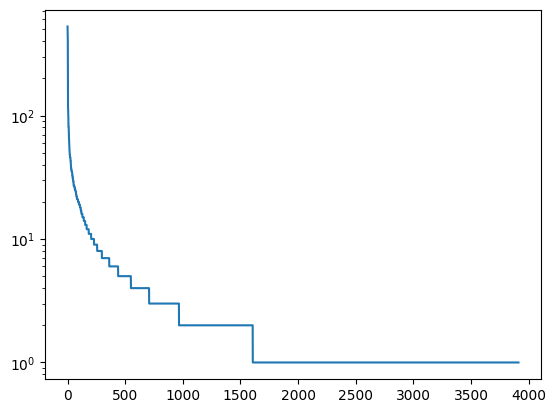

In [11]:
# Plot the distribution of word occurrences in the 'before' dataset.
plt.figure()
plt.semilogy(-np.sort(-np.sum(Mwd_before,axis=1)))
plt.savefig(out_dir+out_file+"_statistics_after.png")

In [13]:
# Filter out words with low occurrence
select_before = (np.sum(Mwd_before,axis=1)>2)
Mwd_before = Mwd_before[select_before,:]
words_before = words_before[select_before]
# Filter out documents that do not contain words
select_before = (np.sum(Mwd_before,axis=0)>0)
Mwd_before = Mwd_before[:,select_before]
documents_before = documents_before[select_before]
# Display the shape of the final word occurrence matrix after filtering
display(Mwd_before.shape)

(967, 1906)

In [14]:
# Save the result
pickle.dump([Mwd_before,words_before,documents_before], open(out_dir+out_file+"_after_occurrences.p", "wb"))
# c,d,e = pickle.load(open(out_dir+out_file+"_occurrences.p","rb"))

In [15]:
in_dir = "/content/drive/MyDrive/Network_science/"
in_file = "final_feminism_reddit__after"

# Load the serialized word occurrence data
Mwd, words, documents = pickle.load(open(in_dir+in_file+"_occurrences.p","rb"))
Mwd = sps.csr_matrix(Mwd)

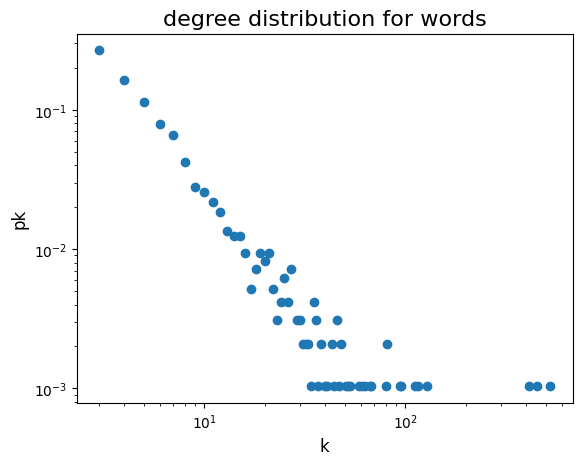

In [16]:
# Calculate the degree distribution for words within the word occurrence matrix
dw = np.squeeze(np.asarray(Mwd.sum(axis=1))) # words degrees
k = np.unique(dw)
pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()
plt.loglog(k,pk,'o')
plt.title("degree distribution for words", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()


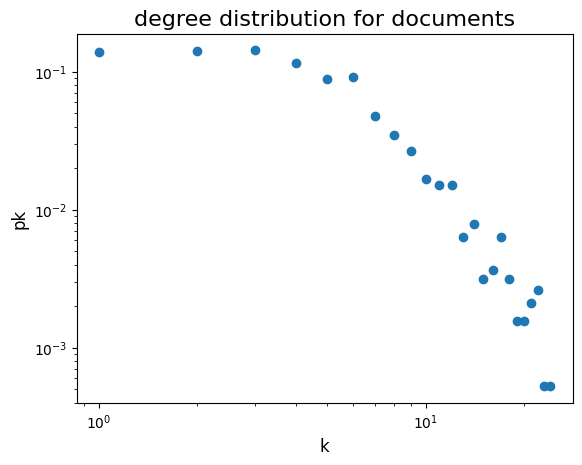

In [17]:
# Calculate the degree distribution for documents within the word occurrence matrix
dd = np.squeeze(np.asarray(Mwd.sum(axis=0))) # documents degrees
k = np.unique(dd)
pk = np.histogram(dd,np.append(k,k[-1]+1))[0]
pk = pk/pk.sum()
Pk = 1-np.cumsum(pk)
fig = plt.figure()
plt.loglog(pk,'o')
plt.title("degree distribution for documents", size=16)
plt.xlabel("k", size=12)
plt.ylabel("pk", size=12)
plt.show()

In [18]:
# Remove elements that are excessively central
Mwd, words, documents = clean_Mwd_matrix(Mwd,words,documents)
# Construct probability matrices
Pwd, Pww, Pdd, Paa = probability_matrices(Mwd, tform=False)

removing: feminism NOUN dude VERB wtf PROPN  


In [19]:
# Start a timer to measure the execution time
tic = time.time()

# Generate a graph from the document-document probability matrix
A = sps.csr_matrix(Pdd)
G = ig.Graph.Adjacency((A > 0).toarray().tolist())
G.es['weight'] = np.array(A[A.nonzero()])[0]

# Apply the Louvain algorithm to the graph for community detection
part = louvain.find_partition(G, louvain.ModularityVertexPartition,
                                 weights='weight')

# Define a function to convert the Louvain partitioning result into a community assignment matrix (C)
def partition_to_C(part):
  C = sps.csr_matrix((Pdd.shape[0],len(part)))
  for i in range(len(part)):
    C[np.array(part[i]),i] = 1
  return C

# Convert the Louvain partition into a community assignment matrix
C_l = partition_to_C(part)

# Record the time taken to perform the initial Louvain
et_louv = time.time()-tic

# Apply a refinement step with a 'soft' Louvain algorithm variant
C_sl, _, _ = my_soft_louvain(Pdd, C_l)

# Record the total execution time
et_slouv = time.time()-tic

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[1683, 1683]
192.3330444827413
48.083261120685215
9.899494936611667
5.656854249492381
4.242640687119286
0.0
[1683, 30]
4.242640687119286
0.0
[1683, 29]
0.0


In [20]:
!pip install bertopic
from bertopic import BERTopic

In [21]:
# Load the cleaned text data
df2 = pd.read_excel("/content/drive/MyDrive/Network_science/final_feminism_reddit_after_cleaned.xlsx")
df2["id"] = np.array([str(i) for i in df2["id"]])

# Filter 'df2' to include only those documents that are present in the community assignment matrix 'Pcc'
documents = np.array([str(i) for i in documents])
df2 = df2.loc[df2['id'].isin(documents)]
df2.index = np.array(range(len(df2)))

# Reinsert hashtags into the cleaned text
df2["text_deep_clean2"] = [str(df2["text_deep_clean"][i]) + " #" +
                           df2["hashtags"][i][2:-2].replace("', '"," #")
                           for i in range(len(df2))]

In [22]:
# Start a timer to measure the execution time for topic modeling with BERTopic
tic = time.time()

# Initialize a BERTopic instance for topic modeling
bert_model = BERTopic()

# Perform topic modeling on the documents using BERTopic
docs = list(df2["title"])
topics, probabilities = bert_model.fit_transform(docs)

# Define a function to convert the topic assignments into a community assignment matrix
def topics_to_C(topics):
  # extract community assignments
  C = sps.csr_matrix((len(topics),max(topics)+2))
  for i in range(C.shape[1]):
    C[np.array(topics)==(i-1),i] = 1
  # remove zero assignments
  C = C[:,np.unique(scipy.sparse.find(C)[1])]
  return C

# Convert the list of topic assignments into a community assignment
C_b = topics_to_C(topics)

# Calculate and capture the execution time
et_bert = time.time()-tic

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [23]:
# Initialize a DataFrame
df = pd.DataFrame(data={'data':[],'algo':[],'time':[],'c#':[],
                        'NMI':[],'Q':[],'Ncut':[],'InfoMap':[]})

# Compute the Infomap ranking vector 'r'
r = infomap_rank(Pdd)


In [24]:
# Evaluate clustering performance metrics for the hard Louvain method
stats = clustering_statistics(C_l,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"hard Louvain Pdd",et_louv,C_l.shape[1]] + stats

# Evaluate clustering performance metrics for the soft Louvain method
stats = clustering_statistics(C_sl,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"soft Louvain Pdd",et_slouv,C_sl.shape[1]] + stats

# Evaluate clustering performance metrics for the hard BERTopic method
stats = clustering_statistics(C_b,Pwd,Pdd,r)
# Store them into the dataframe
df.loc[len(df)] = [in_file,"BERTopic",et_bert,C_b.shape[1]] + stats


/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [25]:
# Display the result
display(df)

,data,algo,time,c#,NMI,Q,Ncut,InfoMap
0,final_feminism_reddit__after,hard Louvain Pdd,1.964836,30,0.526342,0.368386,0.586316,-0.008558
1,final_feminism_reddit__after,soft Louvain Pdd,14.436413,29,0.525547,0.369117,0.585696,-0.008034
2,final_feminism_reddit__after,BERTopic,59.976783,35,0.472692,0.188759,0.710323,0.041157


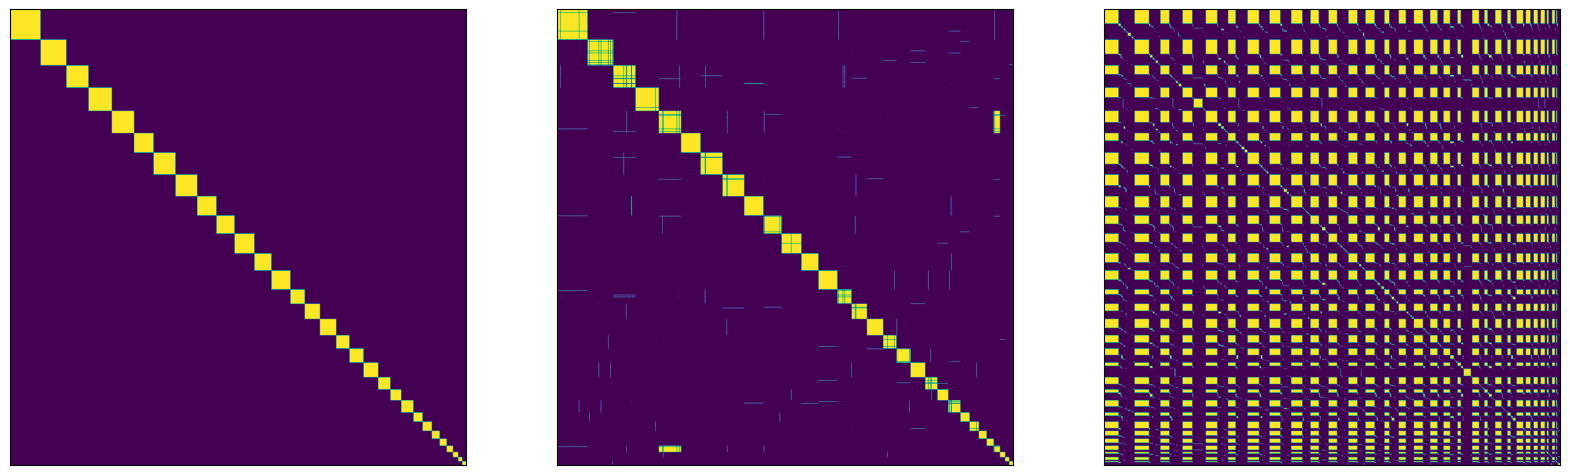

In [26]:
#  Visualize the community structures
plot_community_patterns([C_l,C_sl,C_b],nrows=1,ncols=3,refs=[0,2])

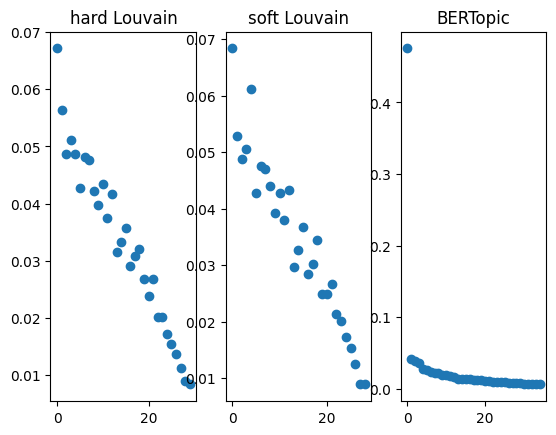

In [27]:
# visualizes the distribution of documents across communities
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(np.array(C_l.sum(axis=0))[0]/C_l.sum(),'o')
ax1.set_title('hard Louvain')
ax2.plot(np.array(C_sl.sum(axis=0))[0]/C_sl.sum(),'o')
ax2.set_title('soft Louvain')
ax3.plot(np.array(C_b.sum(axis=0))[0]/C_b.sum(),'o')
ax3.set_title('BERTopic');

In [28]:
# Initialize a BERTopic model customized for the communities identified by Louvain
docs = list(df2["text_deep_clean2"])
bert_model1 = bertopic_overwrite(bert_model,docs,C_l)

# Visualize the top words for each topic (community) identified
bert_model1.visualize_barchart(topics = range(C_l.shape[1]),
                               n_words = 8,
                               title = "Louvain results")

In [29]:
# BERTopic second

# use the clean text in order to get a more meaningful description
docs = list(df2["text_deep_clean2"])
bert_model2 = bertopic_overwrite(bert_model,docs,C_b)

# visualize topic description
bert_model2.visualize_barchart(topics = range(C_b.shape[1]),
                               n_words = 8,
                               title = "BERTopic results")

In [30]:
topics = bert_model1.get_topics()
print(topics)

{0: [('choice', 0.05593450296285127), ('korea', 0.050901140345668), ('vote', 0.04405194192187558), ('movement', 0.043026439546351256), ('south', 0.03567927198993448), ('education', 0.032275200323591394), ('system', 0.03121936299119267), ('ban', 0.02948085822627356), ('problem', 0.02932639713829994), ('crime', 0.028711943359759354)], 1: [('find', 0.08932592976920496), ('relationship', 0.06963157481180729), ('help', 0.06230988391722762), ('subreddit', 0.058789858804459284), ('safe', 0.053860187977848924), ('man', 0.04337874859528607), ('bear', 0.04137462591843194), ('place', 0.03768140402341392), ('level', 0.03611879251633496), ('topic', 0.031679143593742895)], 2: [('boy', 0.06420299014268575), ('gen', 0.062235984266963966), ('turn', 0.04999304298117275), ('result', 0.046164236927351346), ('radical', 0.045472067594309135), ('conversation', 0.04145262492137464), ('poll', 0.04090757928577853), ('white', 0.03683951885441027), ('baby', 0.036393827123319365), ('boomer', 0.035380418563701194)]

In [31]:


topics = bert_model1.get_topics()
new_df = pd.DataFrame.from_dict(topics, orient='index')

ktopics = []

for topic_list in range(0, new_df.shape[1]):
  for topic in range(0, new_df.shape[0]):
      ktopics.append(new_df[topic_list][topic][0])

unique_ktopics  = set(ktopics)
topics_ktopics = list(unique_ktopics)



In [32]:
# Load the CSV file
df = pd.read_excel("/content/drive/MyDrive/Network_science/final_feminism_reddit_after_cleaned.xlsx")

# Extract all keywords from the BERT model's output
keywords = topics_ktopics

df["hashtags_2"] = None
for i in range(len(df["text_deep_clean"])):
  if isinstance(df["text_deep_clean"][i], str):  # Check if text is a string
    hashtags2 = []

    for word in df["text_deep_clean"][i].split():

      if word in keywords:
        #  print(type(word))
          hashtags2.append(str(word))
          df["hashtags_2"][i] = hashtags2



In [33]:


df.to_pickle('/content/drive/MyDrive/Network_science/final_feminism_reddit_after_cleaned.pkl')


comments_df = pd.read_pickle("/content/drive/MyDrive/Network_science/final_feminism_reddit_after_cleaned.pkl")


comments_filtered = comments_df.copy()
column_list = ["id","created", "text_deep_clean", "text_deep_clean_pos", "hashtags_2"]
comments_filtered = comments_filtered[column_list]



In [34]:
#initialize an empty dict
unique_words = {}
for row in comments_filtered["text_deep_clean"]:
    if pd.notna(row):
        # Split the row into words and iterate over them
        for word in row.split(" "):
            #if the word is encountered for the first time add to dict as key and set its value to 0
            unique_words.setdefault(word,0)
            #increase the value (i.e the count) of the word by 1 every time it is encountered
            unique_words[word] += 1

In [35]:
uw_df = pd.DataFrame.from_dict(unique_words, orient='index').reset_index()
uw_df.rename(columns = {'index':'Word', 0:'Count'}, inplace=True)
uw_df.sort_values(by=['Count'], ascending=False, inplace=True)
uw_df

,Word,Count
2,feminism,536
11,man,455
8,woman,413
1,feminist,244
5,think,116
...,...,...
2024,fast,1
2022,severely,1
2021,iceland,1
2020,cook,1


In [36]:
!pip install wordcloud matplotlib
from wordcloud import WordCloud

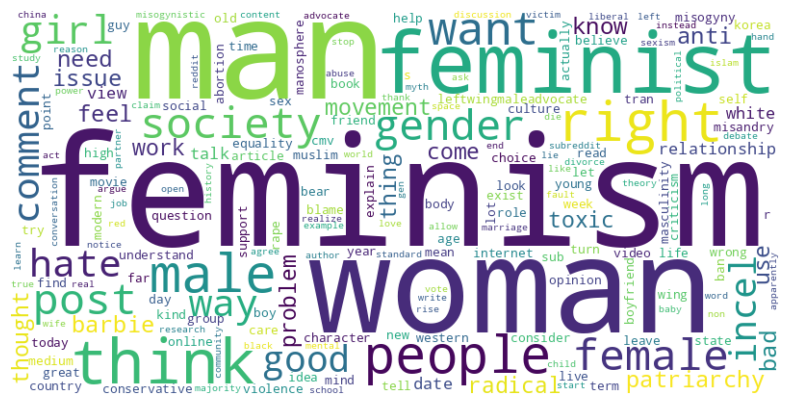

In [37]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(uw_df.set_index('Word').to_dict()['Count'])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [38]:
unique_hashtags = {}


for idx, row in comments_filtered.iterrows():
  hashtag_list = []
  try:
    for hashtag in row["hashtags_2"]:
      unique_hashtags.setdefault("#"+hashtag, 0)
      unique_hashtags['#'+hashtag] += 1
      hashtag_list.append(hashtag)
  except:
      continue

In [39]:


uh_df = pd.DataFrame.from_dict(unique_hashtags, orient='index').reset_index()
uh_df.rename(columns = {'index':'Hashtag', 0:'Count'}, inplace=True)
uh_df.sort_values(by=['Count'], ascending=False, inplace=True)



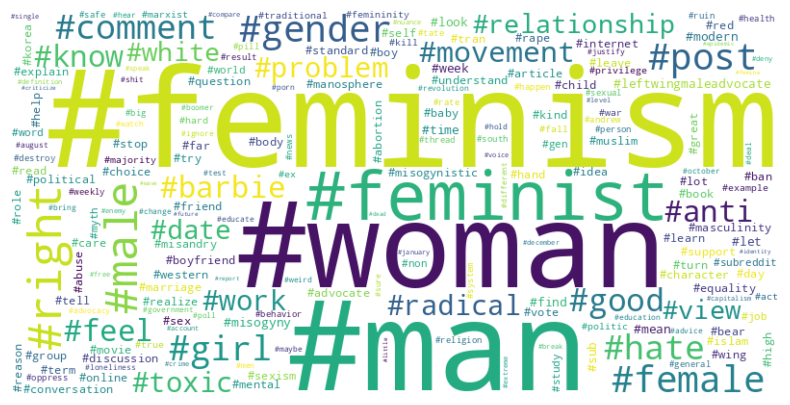

In [40]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(uh_df.set_index('Hashtag').to_dict()['Count'])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Building Network

In [41]:
import itertools
import networkx as nx


uh = unique_hashtags.keys()
uw = unique_words.keys()

In [42]:
network = {}
for index, row in comments_filtered.iterrows():
    combined_list = row['hashtags_2']  # Use keys() to get the list of unique subreddits
    if isinstance(combined_list, list):
      for pair in itertools.product(combined_list, combined_list):
          if pair[0] != pair[1] and not (pair[::-1] in network):
              #breakpoint()
              network.setdefault(pair, 0)
              # Update the weight based on actual occurrences
              network[pair] += 1

network_df = pd.DataFrame.from_dict(network, orient="index")

In [43]:
network_df.reset_index(inplace=True)
network_df.columns = ["pair","weight"]
network_df.sort_values(by="weight",inplace=True, ascending=False)
network_df

,pair,weight
4,"(woman, man)",191
11,"(man, feminism)",109
170,"(man, feminist)",95
33,"(woman, feminism)",95
858,"(man, right)",54
...,...,...
1437,"(politic, man)",1
1436,"(politic, compare)",1
1434,"(politic, government)",1
1433,"(turn, result)",1


In [44]:
#to get weighted graph we need a list of 3-element tuplels (u,v,w) where u and v are nodes and w is a number representing weight
up_weighted = []
for edge in network:
    #we can filter edges by weight by uncommenting the next line and setting desired weight threshold
    #if(network[edge])>1:
    up_weighted.append((edge[0],edge[1],network[edge]))

G = nx.Graph()
G.add_weighted_edges_from(up_weighted)

In [45]:
filename = "/content/drive/MyDrive/Network_science/feminism_edgelist_after_released.csv"

nx.write_weighted_edgelist(G, filename, delimiter=",")


In [46]:
word_nodes = pd.DataFrame.from_dict(unique_words,orient="index")
word_nodes.reset_index(inplace=True)
word_nodes["Label"] = word_nodes["index"]
word_nodes.rename(columns={"index":"Id",0:"delete"},inplace=True)
word_nodes = word_nodes.drop(columns=['delete'])

In [47]:
hashtag_nodes = uh_df.copy()
hashtag_nodes["Label"] = hashtag_nodes["Hashtag"]
hashtag_nodes.rename(columns={"Hashtag":"Id"},inplace=True)
hashtag_nodes = hashtag_nodes.drop(columns=['Count'])



In [48]:
nodelist = hashtag_nodes
nodelist.to_csv("/content/drive/MyDrive/Network_science/feminism_nodelist_after_released.csv",index=False)


a = pd.read_csv("/content/drive/MyDrive/Network_science/feminism_edgelist_after_released.csv")


a.columns = ['Source','Target','Label']


a.to_csv("/content/drive/MyDrive/Network_science/feminism_edgelist_after_released.csv",index=False)

